## Импорт

In [1]:
!pip install ninja
!pip install imageio-ffmpeg
!pip install -U -q PyDrive
!pip install lpips
!pip install pytorch_msssim
!pip install pytorch-ignite

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 307.2/307.2 kB 2.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.8/53.8 kB 665.5 kB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 272.4/272.4 kB 2.3 MB/s eta 0:00:00


In [2]:

from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials
# Authenticate and create the PyDrive client.
# This only needs to be done once per notebook.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

%mkdir raw_images
!git clone https://github.com/NVlabs/stylegan2-ada-pytorch
%cd stylegan2-ada-pytorch
!git clone https://github.com/denkogit/stylegan2_models


!mkdir pretrained_models
%cd pretrained_models
!wget https://nvlabs-fi-cdn.nvidia.com/stylegan2-ada-pytorch/pretrained/ffhq.pkl
!wget https://github.com/davisking/dlib-models/raw/master/shape_predictor_68_face_landmarks.dat.bz2
!bzip2 -d /content/stylegan2-ada-pytorch/pretrained_models/shape_predictor_68_face_landmarks.dat.bz2

file_id = '1cUv_reLE6k3604or78EranS7XzuVMWeO' # URL id.
downloaded = drive.CreateFile({'id': file_id})
downloaded.GetContentFile('e4e_ffhq_encode.pt')

%cd ..

# ref https://github.com/Puzer/stylegan-encoder/blob/master/align_images.py
# !git clone https://github.com/omertov/encoder4editing


Cloning into 'stylegan2-ada-pytorch'...
remote: Enumerating objects: 131, done.
remote: Counting objects: 100% (3/3), done.
remote: Compressing objects: 100% (3/3), done.
remote: Total 131 (delta 0), reused 1 (delta 0), pack-reused 128
Receiving objects: 100% (131/131), 1.13 MiB | 7.24 MiB/s, done.
Resolving deltas: 100% (57/57), done.
/content/stylegan2-ada-pytorch
Cloning into 'stylegan2_models'...
remote: Enumerating objects: 57, done.
remote: Counting objects: 100% (57/57), done.
remote: Compressing objects: 100% (48/48), done.
remote: Total 57 (delta 14), reused 48 (delta 7), pack-reused 0
Receiving objects: 100% (57/57), 25.54 KiB | 1.50 MiB/s, done.
Resolving deltas: 100% (14/14), done.
/content/stylegan2-ada-pytorch/pretrained_models
--2023-12-14 12:36:36--  https://nvlabs-fi-cdn.nvidia.com/stylegan2-ada-pytorch/pretrained/ffhq.pkl
Resolving nvlabs-fi-cdn.nvidia.com (nvlabs-fi-cdn.nvidia.com)... 52.84.18.74, 52.84.18.79, 52.84.18.33, ...
Connecting to nvlabs-fi-cdn.nvidia.com (

In [3]:
import pickle
import torch
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from stylegan2_models.e4e.model_utils import load_e4e_standalone
import torchvision.transforms as transforms

## Загрузка моделей

In [4]:
device = "cuda:0"
model_path = "/content/stylegan2-ada-pytorch/pretrained_models/ffhq.pkl"

with open(model_path, "rb") as f:
    face_generator = pickle.load(f)['G_ema'].cuda()
    #face_generator = pickle.load(f)['G_ema'].cpu()

e4e_model, _ = load_e4e_standalone("/content/stylegan2-ada-pytorch/pretrained_models/e4e_ffhq_encode.pt")

image2e4etensor = transforms.Compose([transforms.ToTensor(),
                                      transforms.Resize((256,256)),
                                      transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])])

## Генерация

In [5]:
import random

In [6]:
def plot_image(tensor, plot_size=(10,10)):
  tensor = (tensor.permute(0, 2, 3, 1) * 127.5 + 128).clamp(0, 255).to(torch.uint8)
  img = Image.fromarray(tensor[0].cpu().numpy(), 'RGB')
  plt.rcParams["figure.figsize"] = plot_size
  plt.imshow(img)

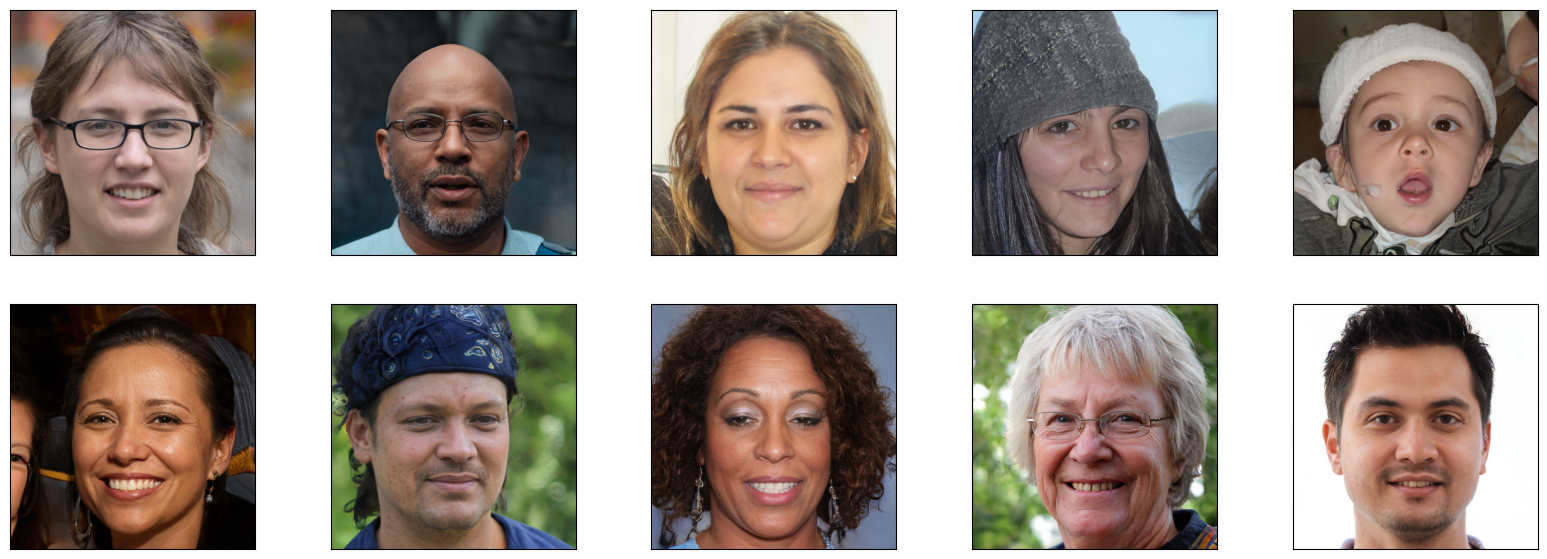

In [14]:
noise_mode = 'const'
label = 0
images=[]
plt.rcParams ['figure.figsize'] = [20, 7]

for i in range(10):
  z = torch.from_numpy(np.random.RandomState(random.randint(0, 99999999)).randn(1, face_generator.z_dim)).to(device)
  ws = face_generator.mapping(z, label, truncation_psi=(0.8))

  generated_tensor = face_generator.synthesis(ws, noise_mode=noise_mode, force_fp32=True)
  tensor = (generated_tensor.permute(0, 2, 3, 1) * 127.5 + 128).clamp(0, 255).to(torch.uint8)
  img = tensor[0].cpu().numpy()

  images.append(img)
  plt.subplot(2, 5, i+1)
  plt.xticks([])
  plt.yticks([])
  plot_image(generated_tensor)

##Интерполяция

In [15]:
latents = []

for i in range(2):
  target_uint8 = np.array(images[i], dtype = np.uint8)
  e4e_tensor = image2e4etensor(target_uint8).to(device).unsqueeze(0)
  #latent_vector = e4e_model(e4e_tensor).detach().cpu()
  latent_vector = e4e_model(e4e_tensor).detach().cuda()
  latents.append(latent_vector)

/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


<ipython-input-20-d6b588d0ae30>:22: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  concatted_img = Image.fromarray(np.hstack((img for img in imgs)), 'RGB')


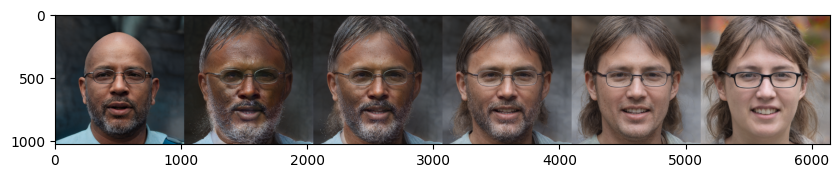

In [20]:
def interpolate(face_generator, latent1, latent2, psi=0.5):
    latent1 = latent1.clone()
    latent2 = latent2.clone()
    indeces = [5,6,7,8,9,10,11,12]
    for i in indeces:
        latent1[:, i] = latent2[:, i].lerp(latent1[:, i], psi)

    generated_tensor = face_generator.synthesis(latent1, noise_mode='const', force_fp32=True)
    return generated_tensor

imgs = []
imgs.append(images[1])
for i in [i/10 for i in range(-10, 10, 5)]:
  #interpolation = interpolate(face_generator.cpu(), latents[0], latents[1], psi=i)
  interpolation = interpolate(face_generator.cuda(), latents[0], latents[1], psi=i)
  tensor = (interpolation.permute(0, 2, 3, 1) * 127.5 + 128).clamp(0, 255).to(torch.uint8)
  img = tensor[0].cpu().numpy()
  #img = tensor[0].cuda().numpy()

  imgs.append(img)
imgs.append(images[0])
concatted_img = Image.fromarray(np.hstack((img for img in imgs)), 'RGB')

plt.imshow(concatted_img)

## Замена лиц

In [21]:
!pip install lpips

In [22]:
from google.colab import drive
drive.mount('/content/drive')

import PIL
import os
import numpy as np
import torch
import lpips
import torch.nn as nn
import torchvision.transforms as transforms
from pytorch_msssim import ms_ssim
from lpips import LPIPS

Mounted at /content/drive


In [24]:
device = "cuda:0"
class Rec_loss(nn.Module):
    def __init__(self):
        super().__init__()
        self.l1_criterion = torch.nn.L1Loss(reduction='mean')


    def forward(self, target, synth):

        target = torch.add(target, 1.0)
        target = torch.mul(target, 127.5)
        target = target / 255

        synth = torch.add(synth, 1.0)
        synth = torch.mul(synth, 127.5)
        synth = synth / 255

        loss = torch.mean(1 - ms_ssim(synth, target, data_range=1, size_average=True))
        return loss


class Lpips_loss(nn.Module):
    def __init__(self, device):
        super().__init__()
        self.lpips_loss = LPIPS(net='vgg')
        self.lpips_loss.to(device)
        self.lpips_loss.eval()

    def forward(self, target, synth):
        return torch.mean(self.lpips_loss(target, synth))

def broadcast_w_sg(w_batch, cast_n=18):
    input_ws = []
    for w in w_batch:
        w_broadcast = torch.broadcast_to(w, (cast_n, 512))
        input_ws.append(w_broadcast)
    return torch.stack(input_ws)


def image2tensor_norm(image):
    transform = transforms.Compose([transforms.ToTensor(),
                                   transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])])
    tensor = transform(image)
    return tensor

def load_image(img_path, img_size=1024):

  target_pil = PIL.Image.open(img_path).convert('RGB')
  target_pil = target_pil.resize((img_size, img_size))
  return target_pil



#target_image = load_image('/content/drive/MyDrive/SyntheticMedia/Dataset/Man.jpg')
#target_image = load_image('/content/drive/MyDrive/celebs/pins_Jessica Barden/Jessica Barden115_1385.jpg')
target_image = load_image('/content/fase.jpg')
target_tensor = image2tensor_norm(target_image).cuda().unsqueeze(0)

lpips = Lpips_loss(device)
rec = Rec_loss()

def get_average_latent_space_vector(w_avg_samples = 10000, seed = 42):
  z_samples = torch.from_numpy(np.random.RandomState(seed).randn(w_avg_samples, face_generator.z_dim)). to(device)
  w_samples = face_generator.mapping(z_samples, None)
  w_samples = w_samples[:, :1, :].cpu().numpy().astype(np.float32)
  #w_samples = w_samples[:, :1, :].cuda().numpy().astype(np.float32)
  w_avg = np.mean(w_samples, axis=0, keepdims=True)
  w_std = (np.sum((w_samples - w_avg) ** 2) / w_avg_samples) ** 0.5
  return w_avg

w_avg = get_average_latent_space_vector()
w_opt = torch.tensor(w_avg, dtype=torch.float32, device=device, requires_grad=True)

optimizer = torch.optim.Adam([w_opt], lr = 0.05)

Setting up [LPIPS] perceptual loss: trunk [vgg], v[0.1], spatial [off]


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth
100%|██████████| 528M/528M [00:09<00:00, 58.8MB/s]


Loading model from: /usr/local/lib/python3.10/dist-packages/lpips/weights/v0.1/vgg.pth


In [29]:
faces = []

''''seed = random.randint(64364, 4273462)
z = torch.from_numpy(np.random.RandomState(seed).randn(1, face_generator.z_dim)).to(device)
ws = face_generator.mapping(z, c=0, truncation_psi=(0.8))

generated_tensor = face_generator.synthesis(ws, noise_mode = 'const', force_fp32=True)
tensor = (generated_tensor.permute(0, 2, 3, 1) * 127.5 + 128).clamp(0, 255).to(torch.uint8)
#img = tensor[0].cuda().numpy()
img = tensor[0].cpu().numpy()'''
faces.append(img)

In [26]:
#!pip install tqdm
import tqdm

In [36]:
steps = 800

for step in tqdm.tqdm(range(steps)):
  synth_tensor = face_generator.synthesis(broadcast_w_sg(w_opt), noise_mode='const')

  lpips_loss = lpips(synth_tensor, target_tensor)
  rec_loss = rec(synth_tensor, target_tensor)

  loss = lpips_loss + rec_loss

  optimizer.step()
  optimizer.zero_grad(set_to_none=True)
  loss.backward()

generated_tensor = face_generator.synthesis(broadcast_w_sg(w_opt), noise_mode='const', force_fp32=True)
tensor = (generated_tensor.permute(0, 2, 3, 1) * 127.5 + 128).clamp(0,255).to(torch.uint8)
faces.append(tensor[0].cpu().numpy())

100%|██████████| 800/800 [07:52<00:00,  1.69it/s]


<ipython-input-25-51d1d86b6411>:2: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  concatted_img = Image.fromarray(np.hstack((img for img in faces)), 'RGB')


0.8287653923034668


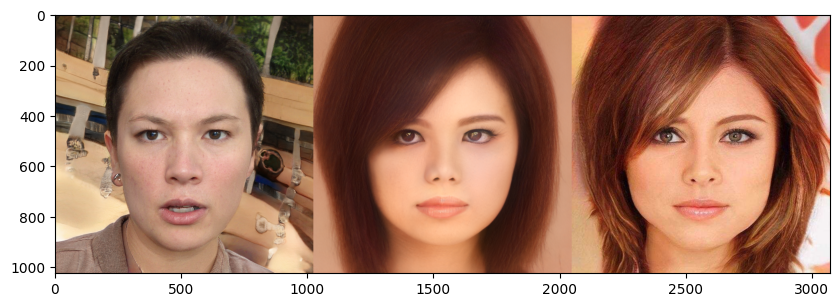

In [ ]:
faces.append(target_image)
concatted_img = Image.fromarray(np.hstack((img for img in faces)), 'RGB')

plt.imshow(concatted_img)

print(loss.item())



---



---



In [38]:
import os
import glob
import pandas as pd
from sklearn.decomposition import PCA
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.offsetbox import OffsetImage, AnnotationBbox



images_path = "/content/drive/MyDrive/celebs"
save_path = "/content/e4e_invertion"

data = []
for persone in os.listdir(images_path):
    person_images = os.path.join(images_path, persone)
    save_folder = os.path.join(save_path, persone)
    os.makedirs(save_folder, exist_ok=True)
    for image_name in os.listdir(person_images):
      image_path = os.path.join(person_images, image_name)

      target_pil = Image.open(image_path).convert('RGB')
      target_uint8 = np.array(target_pil, dtype=np.uint8)

      e4e_tensor = image2e4etensor(target_uint8).to(device).unsqueeze(0)

      latent_vector = e4e_model(e4e_tensor).detach().cpu()
      latent_path = os.path.join(save_folder, f"{image_name[:-3]}.pt")

      torch.save(latent_vector, latent_path)
      data.append([persone, image_name, image_path, latent_path])

df = pd.DataFrame(data, columns = ['key', 'image_name', 'image_path', 'latent_path'])

/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across th

KeyboardInterrupt: ignored

In [39]:
df = pd.DataFrame(data, columns = ['key', 'image_name', 'image_path', 'latent_path'])

In [ ]:
! mv /content/stylegan2-ada-pytorch/editing /content

In [46]:
image_path = "/content/drive/MyDrive/celebs/pins_Zendaya/Zendaya0_1787.jpg"
#image_path = "/content/drive/MyDrive/celebs/pins_Amanda Crew/Amanda Crew106_6.jpg"
target_pil = Image.open(image_path).convert('RGB').resize((1024,1024))
target_uint8 = np.array(target_pil, dtype=np.uint8)

e4e_tensor = image2e4etensor(target_uint8).to(device).unsqueeze(0)
latent_vector1 = e4e_model(e4e_tensor)

In [47]:
image_path = "/content/drive/MyDrive/celebs/pins_Emma Watson/Emma Watson111_1853.jpg"
#image_path ="/content/drive/MyDrive/celebs/pins_Alexandra Daddario/Alexandra Daddario103_220.jpg"
target_pil = Image.open(image_path).convert('RGB').resize((1024,1024))
target_uint8 = np.array(target_pil, dtype=np.uint8)

e4e_tensor = image2e4etensor(target_uint8).to(device).unsqueeze(0)
latent_vector2 = e4e_model(e4e_tensor)

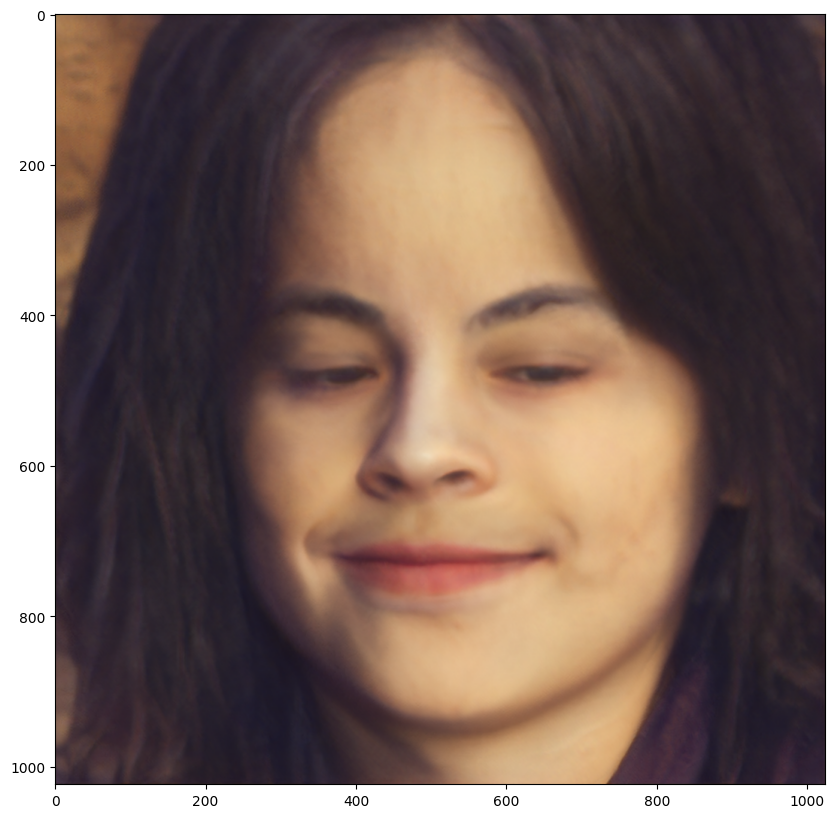

In [50]:
from IPython.display import display, FileLink
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets
import torch



def interpolate(latent1, latent2, psi=0.5):
    latent1 = latent1.clone()
    latent2 = latent2.clone()
    indeces = [5,6,7,8,9,10,11,12]
    #indeces = [0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17]
    for i in indeces:
        latent1[:, i] = latent2[:, i].lerp(latent1[:, i], psi)

    generated_tensor = face_generator.synthesis(latent1, noise_mode='const', force_fp32=True)
    plot_image(generated_tensor)



latent1=torch.load("/content/e4e_invertion/pins_Zendaya/Zendaya0_1787..pt").to(device)
latent2=torch.load("/content/e4e_invertion/pins_Emma Watson/Emma Watson111_1853..pt").to(device)

# print(x.size())

''''interactive(interpolate, latent1=fixed(latent1), latent2=fixed(latent2),
            psi=widgets.FloatSlider(value=0.5, min=-1.0, max=1.0, step=0.1))'''

interpolate(latent_vector2, latent_vector1, psi=1)

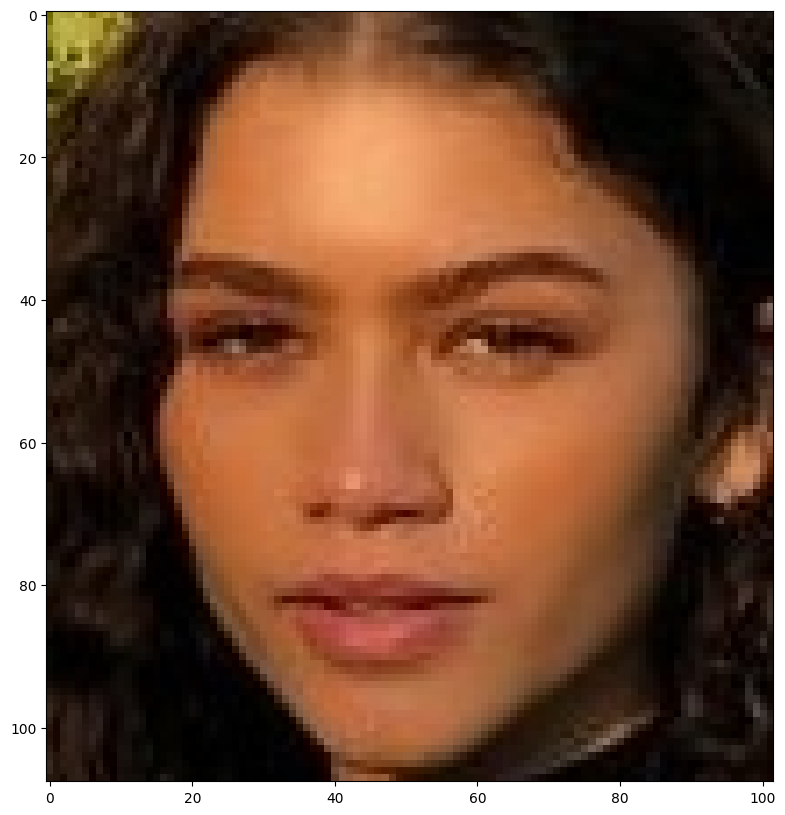

In [52]:
image = Image.open('/content/drive/MyDrive/celebs/pins_Zendaya/Zendaya0_1787.jpg')
plt.imshow(image)

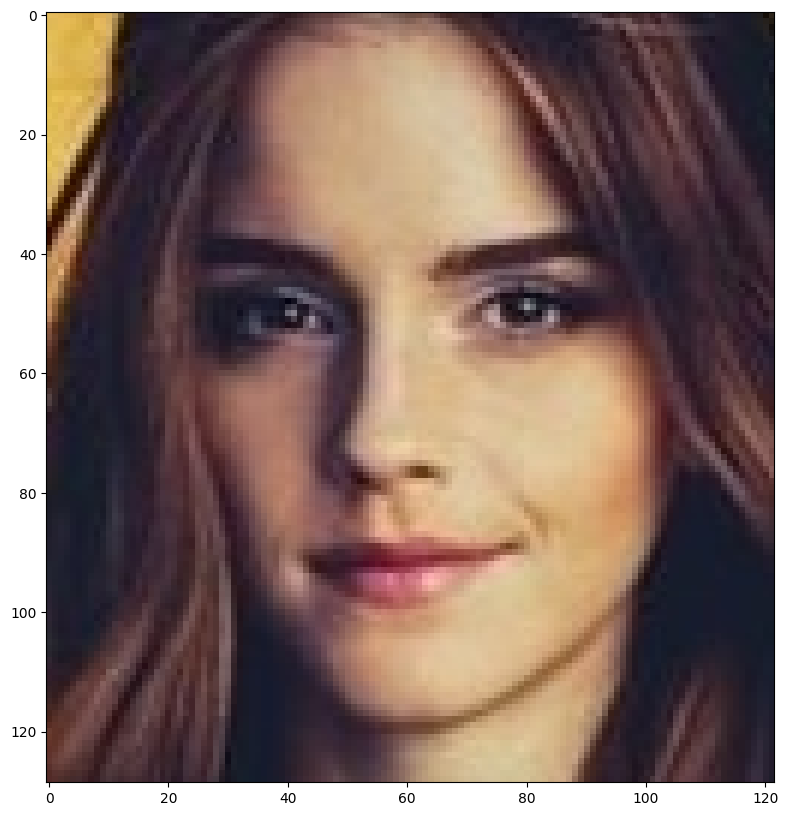

In [51]:
image = Image.open('/content/drive/MyDrive/celebs/pins_Emma Watson/Emma Watson111_1853.jpg')
plt.imshow(image)